In [4]:
import pandas as pd

# Path to the TSV file
tsv_file_path = r"C:\Users\khush\Downloads\test.tsv"

# Path to save the CSV file
csv_file_path = r"C:\Users\khush\Downloads\test.csv"

# Read the TSV file
data = pd.read_csv(tsv_file_path, sep='\t')

# Save as a CSV file
data.to_csv(csv_file_path, index=False)

print(f"TSV file has been converted to CSV and saved at: {csv_file_path}")


TSV file has been converted to CSV and saved at: C:\Users\khush\Downloads\test.csv


In [10]:
import re
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import nltk

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Load data
data_train = pd.read_csv(r"C:\Users\khush\Downloads\train.csv")
data_test = pd.read_csv(r"C:\Users\khush\Downloads\test.csv")

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stopwords.words('english')]
    return ' '.join(text)

# Apply preprocessing
data_train['cleaned_title'] = data_train['title'].apply(clean_text)
data_train['cleaned_text'] = data_train['text'].apply(clean_text)
data_test['cleaned_title'] = data_test['title'].apply(clean_text)
data_test['cleaned_text'] = data_test['text'].apply(clean_text)

# Additional Feature Engineering
def feature_engineering(data):
    data['title_length'] = data['title'].apply(lambda x: len(str(x).split()))
    data['text_length'] = data['text'].apply(lambda x: len(str(x).split()))
    sia = SentimentIntensityAnalyzer()
    data['title_sentiment'] = data['title'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
    data['text_sentiment'] = data['text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
    data['title_word_density'] = data['title_length'] / (data['text_length'] + 1)  # Avoid division by zero
    return data

# Engineer features
data_train = feature_engineering(data_train)
data_test = feature_engineering(data_test)

# Vectorization
tfidf_title = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))  # Include bigrams
tfidf_text = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and Transform Train Data
title_features_train = tfidf_title.fit_transform(data_train['cleaned_title'])
text_features_train = tfidf_text.fit_transform(data_train['cleaned_text'])

# Transform Test Data
title_features_test = tfidf_title.transform(data_test['cleaned_title'])
text_features_test = tfidf_text.transform(data_test['cleaned_text'])

# Dimensionality Reduction
svd_title = TruncatedSVD(n_components=300, random_state=42)  # Reduce to 300 dimensions
svd_text = TruncatedSVD(n_components=300, random_state=42)

title_features_train = svd_title.fit_transform(title_features_train)
text_features_train = svd_text.fit_transform(text_features_train)
title_features_test = svd_title.transform(title_features_test)
text_features_test = svd_text.transform(text_features_test)

# Combine Features for Train and Test
X_train = np.hstack((title_features_train, text_features_train, 
                     data_train[['title_length', 'text_length', 'title_sentiment', 
                                 'text_sentiment', 'title_word_density']].values))
X_test = np.hstack((title_features_test, text_features_test, 
                    data_test[['title_length', 'text_length', 'title_sentiment', 
                               'text_sentiment', 'title_word_density']].values))

# Define Target Variable
y_train = data_train['label']  # Replace 'label' with the correct column name
y_test = data_test['label']    # Replace 'label' with the correct column name

# Handle Class Imbalance
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define Models with Hyperparameter Tuning
param_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), 
                   param_xgb, cv=3, scoring='accuracy', n_jobs=-1)

param_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

rf = GridSearchCV(RandomForestClassifier(random_state=42), param_rf, cv=3, scoring='accuracy', n_jobs=-1)

# Train Models
xgb.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Ensemble Model
voting_clf = VotingClassifier(estimators=[
    ('XGBoost', xgb.best_estimator_),
    ('Random Forest', rf.best_estimator_),
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42))
], voting='soft', n_jobs=-1)

voting_clf.fit(X_train, y_train)

# Evaluate Models
y_pred = voting_clf.predict(X_test)
y_proba = voting_clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_proba)

print("Voting Classifier Results:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC:", auc_roc)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\khush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\khush\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:46:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Voting Classifier Results:
Accuracy: 0.9894762307971453
Precision: 0.9853014449427006
Recall: 0.9929701230228472
F1 Score: 0.9891209203451294
AUC-ROC: 0.9994502194550932


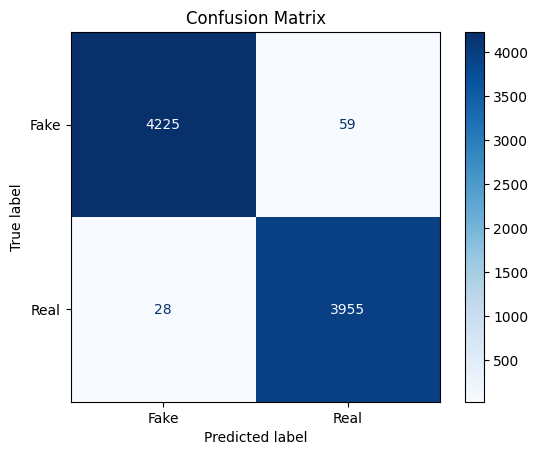

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


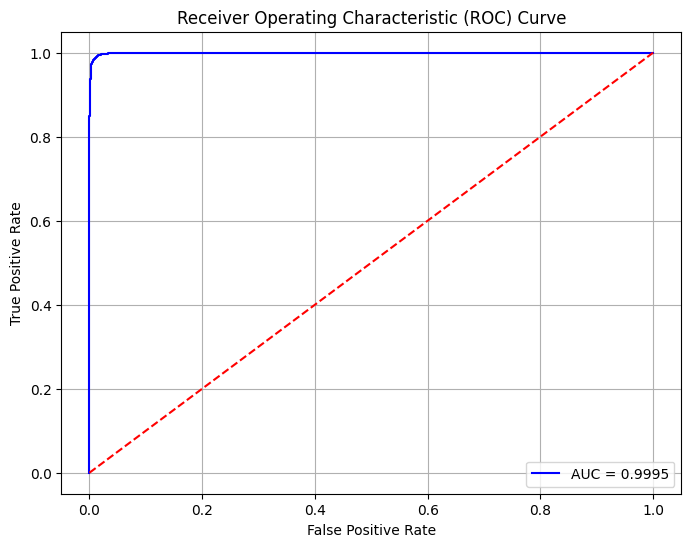

In [12]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


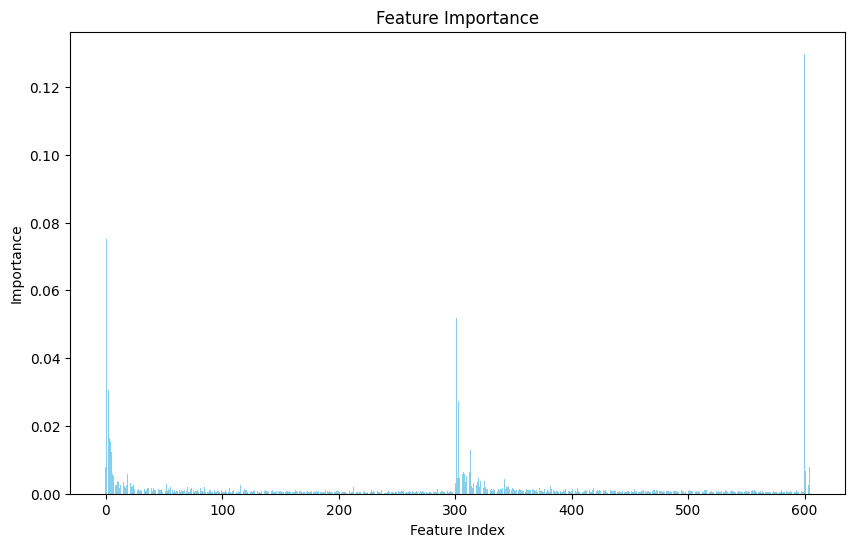

In [13]:
# Extract feature importance from XGBoost and Random Forest
xgb_importance = xgb.best_estimator_.feature_importances_
rf_importance = rf.best_estimator_.feature_importances_

# Average feature importance
combined_importance = (xgb_importance + rf_importance) / 2

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(combined_importance)), combined_importance, color='skyblue')
plt.title("Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()


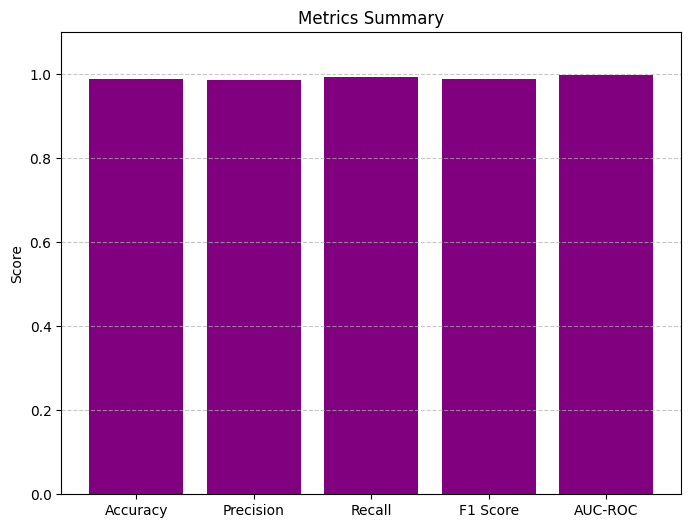

In [14]:
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "AUC-ROC": auc_roc
}

plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color='purple')
plt.title("Metrics Summary")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [15]:

# Prepare Results for Output
output = []
for idx, (title, prediction) in enumerate(zip(data_test['title'], y_pred)):
    output.append([title, int(prediction)])

# Save Results
with open('result.txt', 'w', encoding='utf-8') as f:
    f.write("{\n")
    for item in output:
        f.write(f"  {item},\n")
    f.write("}")

